### Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='4'

In [ ]:
import cv2
import skimage.exposure
from numpy.random import default_rng
import random
import numpy as np
import skimage
import matplotlib.pyplot as plt
import tensorflow as tf
from resnet_vit_keras import vit

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

### Prepare the data

In [5]:
img_w = 2048
img_h = 128
channels = 3
num_classes = 50
batch_size = 32

In [ ]:
def noise_function(image):
    image = image / 255.0
    image = skimage.util.random_noise(image, mode='s&p', amount=1)
    image = image * 255
    return image

In [ ]:
def damage_function(image): 
    patch_size = 32
    num_patches = img_h // patch_size * img_w // patch_size

    for i in range(num_patches):
        prob = 0.2
        if random.choices([0, 1], [1-prob, prob])[0]:
            image[(i//(img_w // patch_size))*patch_size:(i//(img_w // patch_size))*patch_size+patch_size, (i%(img_w // patch_size))*patch_size:(i%(img_w // patch_size))*patch_size+patch_size, :] = np.zeros([patch_size, patch_size, channels])
    return image

In [ ]:
def random_damage_function(image):
    image = image.astype(np.uint8)
    height, width = image.shape[:2]

    # define random seed to change the pattern
    rng = default_rng()

    # create random noise image
    noise = rng.integers(0, 255, (height,width), np.uint8, True)

    # blur the noise image to control the size
    blur = cv2.GaussianBlur(noise, (0,0), sigmaX=15, sigmaY=15, borderType = cv2.BORDER_DEFAULT)

    # stretch the blurred image to full dynamic range
    stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)

    # threshold stretched image to control the size
    thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]

    # apply morphology open and close to smooth out and make 3 channels
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.merge([mask,mask,mask])

    # add mask to input
    result = cv2.add(image, mask)
    return result

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # preprocessing_function = random_damage_function
)    

train_ds = image_generator.flow_from_directory(batch_size=batch_size,
                                                directory='../../datasets/train',
                                                shuffle=True,
                                                target_size=(img_h, img_w),
                                                class_mode = 'categorical',)

validation_ds = image_generator.flow_from_directory(batch_size=batch_size,
                                                    directory='../../datasets/val',
                                                    shuffle=False,
                                                    target_size=(img_h, img_w),
                                                    class_mode = 'categorical')

test_ds = image_generator.flow_from_directory(batch_size=batch_size,
                                                directory='../../datasets/test',
                                                shuffle=False,
                                                target_size=(img_h, img_w),
                                                class_mode = 'categorical')

Found 6458 images belonging to 50 classes.
Found 907 images belonging to 50 classes.
Found 1888 images belonging to 50 classes.


In [8]:
patch_size = 16
num_patches = img_h // patch_size * img_w // patch_size

In [9]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

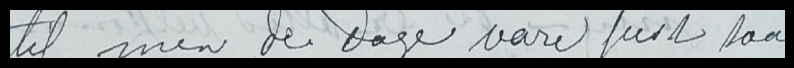

2023-04-24 01:41:39.118283: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Image size: 128 X 2048
Patch size: 16 X 16
Patches per image: 1024
Elements per patch: 768


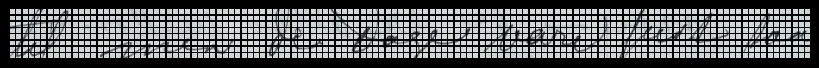

In [11]:
image = next(train_ds)[0][0]/255.0
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('black')
plt.imshow(image)
plt.axis("off")
plt.savefig('./sample_data.png')
plt.show()
plt.close()

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(img_h, img_w))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {img_h} X {img_w}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = img_w // patch_size
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('black')
plt.subplots_adjust(left=0.1,
                bottom=0.1,
                right=0.9,
                top=0.9,
                wspace=0.3,
                hspace=0.3)
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, channels))
    plt.imshow(patch_img)
    plt.axis("off")
plt.savefig('./patches.png')
plt.show()
plt.close()

In [10]:
input_shape = (img_h, img_w, channels)

In [12]:
def create_resnet_vit_classifier():
    model = vit.build_model(
                image_size = (img_h, img_w),
                patch_size = patch_size,
                num_layers = 12,
                hidden_size = 768,
                num_heads = 12,
                name = 'resnet_vit',
                mlp_dim = 3072,
                classes = num_classes,
                dropout = 0.1,
                activation = 'softmax'
            )
    return model

In [13]:
resnet_vit_classifier = create_resnet_vit_classifier()

In [14]:
resnet_vit_classifier.summary()

Model: "resnet_vit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2048, 3)]    0         
                                                                 
 patches_1 (Patches)         (None, None, 768)         0         
                                                                 
 tf.reshape (TFOpLambda)     (None, 768)               0         
                                                                 
 tf.reshape_1 (TFOpLambda)   (None, 16, 16, 3)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 32, 32, 3)        0         
 2D)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 32, 32, 3)        0         
 )                                                      

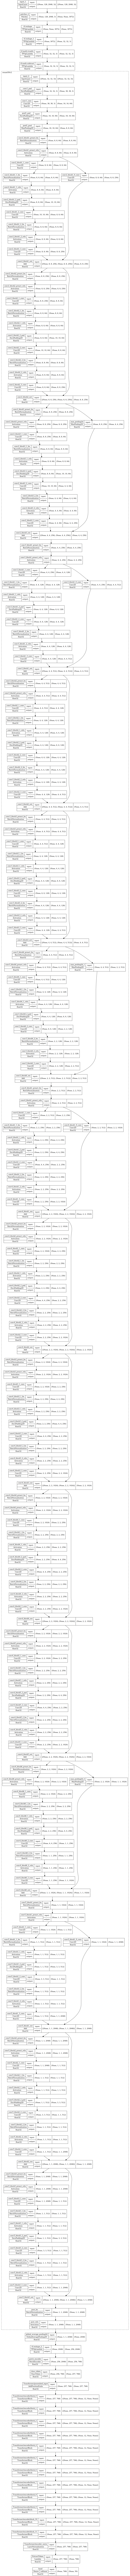

In [15]:
tf.keras.utils.plot_model(
    resnet_vit_classifier,
    to_file='./model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

### Compile, train, and evaluate the mode

In [15]:
learning_rate = 0.00001
num_epochs = 100
checkpoint_filepath = f"../../weights/ResNet_ViT/{patch_size}/checkpoint"

In [16]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

resnet_vit_classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

In [17]:
def run_experiment(model):
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", save_best_only=True, save_weights_only=True),
    ]

    history = model.fit(
        train_ds,
        epochs=num_epochs,
        validation_data=validation_ds,
        callbacks=callbacks,
    )

    return history

In [ ]:
history = run_experiment(resnet_vit_classifier)

### Results

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet_ViT loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('./loss.png')
plt.show()
plt.close()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet_ViT accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.savefig('./accuracy.png')
plt.show()
plt.close()

In [18]:
def model_evaluate(model, test_ds):
    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    with open('results.txt', 'w') as f:
        f.write(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
model_evaluate(resnet_vit_classifier, test_ds)